# Pyiron Workflow for Kanapy
## Analysis of EBSD maps and generation of voxelated RVE

Author: Alexander Hartmaier<br>ICAMS, Ruhr University Bochum, Germany<br>
November 2024

## 1. Prepare system settings

In [1]:
import kanapy as knpy
import numpy as np
from pyiron_workflow import Workflow, function_node


## 2. Definition of required functions as pyiron nodes

In [38]:
# Node to import EBSD maps, uses MTEX, which requires a Matlab installation
@Workflow.wrap.as_function_node
def get_ebsd(fname, show_plot=False):
    ebsd = knpy.EBSDmap(fname, plot=show_plot)
    return ebsd

# Node to extract statistical parameters from EBSD map or a JSON file
@Workflow.wrap.as_function_node
def get_stats(source, Nv=30, size=50, periodic=False):
    if isinstance(source, str):
        if not source[-4:].lower() == 'json':
            raise ValueError('Only JSON file can be imported as statistical paramaters.')
        ms_stats = knpy.import_stats(source)
    else:
        ms_data = source.ms_data[0]  # analyse only data for majority phase with order parameter "0"
        matname = ms_data['name'].lower().replace(' ', '_')  # material name = MTEX Phase name (lower case and w/o blanks)
        gs_param = ms_data['gs_param']  # parameters for lognorm distr of grain size: [std dev., location, scale]
        ar_param = ms_data['ar_param']  # parameters for lognorm distr. of aspect ratios [std dev., location, scale]
        om_param = ms_data['om_param']  # parameters for normal distribution of ellipsoid tilt angles [std dev., mean]
        ms_stats = knpy.set_stats(gs_param, ar_param, om_param,
                          deq_min=8.0, deq_max=19.0, asp_min=0.95, asp_max=3.5,
                          omega_min=0.0, omega_max=np.pi, voxels=Nv, size=size,
                          periodicity=periodic,
                          VF=1.0, phasename=matname, phasenum=0)
        ms_stats['Data'] = {'grain_size': ms_data['gs_data'],
                            'aspect_ratio': ms_data['ar_data']
            
        }
    return ms_stats

@Workflow.wrap.as_function_node
def get_rve(ms_stats, ori=None, hist=None, show_plot=True):
    matname = ms_stats['Phase']['Name']
    if 'Data' in ms_stats.keys():
        gsd = ms_stats['Data']['grain_size']
        ard = ms_stats['Data']['aspect_ratio']
    else:
        gsd = None
        ard = None
    ms = knpy.Microstructure(descriptor=ms_stats, name=matname+'_RVE')
    if show_plot:
        ms.plot_stats_init(gs_data=gsd, ar_data=ard)
    ms.init_RVE()
    ms.pack()
    if show_plot:
        ms.plot_ellipsoids()
    ms.voxelize()
    if ori is not None:
        if isinstance(ori, str):
            if ori.lower() == 'goss':
                ang = [0, 45, 0]    # Euler angle for Goss texture
                omega = 7.5         # kernel half-width
                tdesc = 'unimodal'
            elif ort.lower() == 'copper':
                ang = [90, 35, 45]
                omega = 7.5
                tdesc = 'unimodal'
            elif orti.lower() == 'random':
                ang = None
                omega = None
                tdesc = 'random'
            else:
                raise ValueError('Texture in "ori" not defined. must be "goss", "copper" or "random"')
            ms.generate_orientations(tdesc, ang=ang, omega=omega, 
                                     hist=None, Nbase=1000)
        else:
            ms.generate_orientations(ori)  # downsample ODF of EBSD map to actual number of grains
        plot_ori = True
    else:
        plot_ori = False

    if show_plot:
        ms.plot_voxels(ori=plot_ori, sliced=False) 
        ms.plot_stats_init(show_res=True, gs_data=gsd, ar_data=ard)
    return ms


@Workflow.wrap.as_function_node
def write_rve(ms, ialloy=4):
    # write Abaqus input deck {name}_geom.inp for voxelated structure
    # file {name}_mat.inp contains material definitions for ICAMS CP-UMAT together with Euler angles
    ptag = 'pbc' if ms.rve.periodic else 'non-pbc'
    ftrunc = f'from_ebsd_vox{ms.rve.dim[0]}_gr{ms.Ngr}_{ptag}'
    ms.write_abq(nodes='v', file=ftrunc+'_geom.inp', ialloy=ialloy) # parameter "ialloy" refers to material number of austenite in ICAMS CP-UMAT


In [39]:
# Parameters
fname = '../EBSD_analysis/ebsd_316L_500x500.ang'  # name of ang file to be imported
Nv = 30  # number of voxels per side
size = 50  # side length of generated RVE in micron
periodic = True  # create periodic RVE
ialloy = 4  # numberof material in ICAMS CP-UMAT

# Define workflow
wf = Workflow("kanpy_workflow")
wf.get_ebsd = get_ebsd(fname=fname, show_plot=True)
wf.get_stats = get_stats(source=wf.get_ebsd, Nv=Nv, size=size, periodic=periodic)
wf.get_rve = get_rve(ms_stats=wf.get_stats, ori=wf.get_ebsd, show_plot=True)
wf.write_rve = write_rve(ms=wf.get_rve, ialloy=ialloy)

INFO:pyiron_log:Assigning a channel with the label fname to the io key get_ebsd__fname
INFO:pyiron_log:Assigning a channel with the label show_plot to the io key get_ebsd__show_plot
INFO:pyiron_log:Assigning a channel with the label Nv to the io key get_stats__Nv
INFO:pyiron_log:Assigning a channel with the label size to the io key get_stats__size
INFO:pyiron_log:Assigning a channel with the label periodic to the io key get_stats__periodic
INFO:pyiron_log:Assigning a channel with the label hist to the io key get_rve__hist
INFO:pyiron_log:Assigning a channel with the label show_plot to the io key get_rve__show_plot
INFO:pyiron_log:Assigning a channel with the label ialloy to the io key write_rve__ialloy
INFO:pyiron_log:Assigning a channel with the label fname to the io key get_ebsd__fname
INFO:pyiron_log:Assigning a channel with the label show_plot to the io key get_ebsd__show_plot
INFO:pyiron_log:Assigning a channel with the label Nv to the io key get_stats__Nv
INFO:pyiron_log:Assignin

I found another version of MTEX and remove it from the current search path!
initialize MTEX 5.5.2  .... done!
 
 For compatibility reasons MTEX is not using OpenMP.
 You may want to switch on OpenMP in the file <a href="matlab: edit mtex_settings">mtex_settings.m</a>
 
  I'm going to colorize the orientation data with the 
  standard MTEX ipf colorkey. To view the colorkey do:
 
  ipfKey = ipfColorKey(ori_variable_name)
  plot(ipfKey)


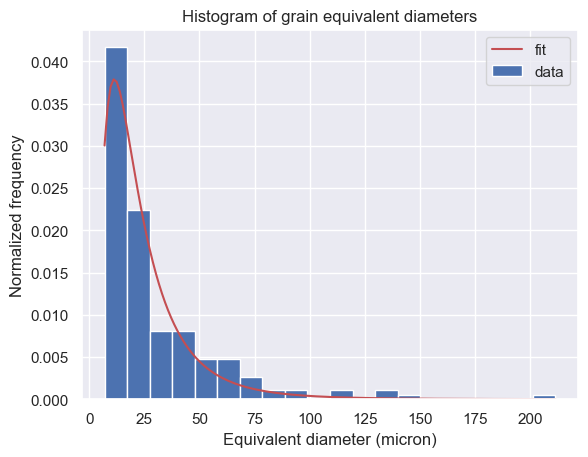

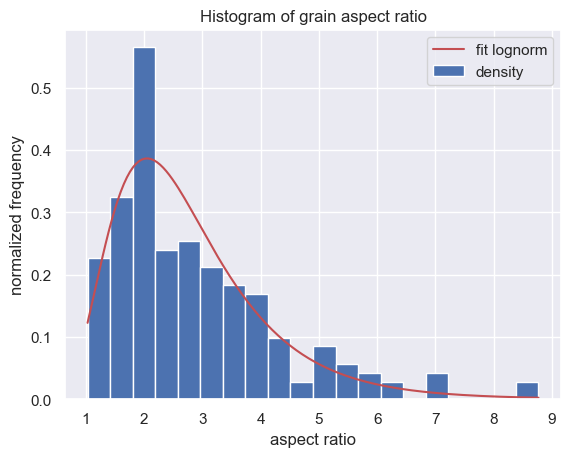

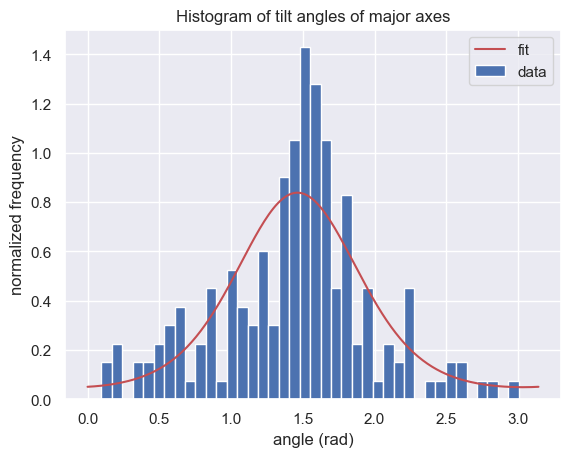

Analyzed microstructure with 183 grains.
Median values: equiv. diameter: 18.973 micron, aspect ratio: 2.519, tilt angle: -12.439°
Std. dev: equivalent diameter: 0.718 micron, aspect ratio: 0.455, tilt angle: 61.657°


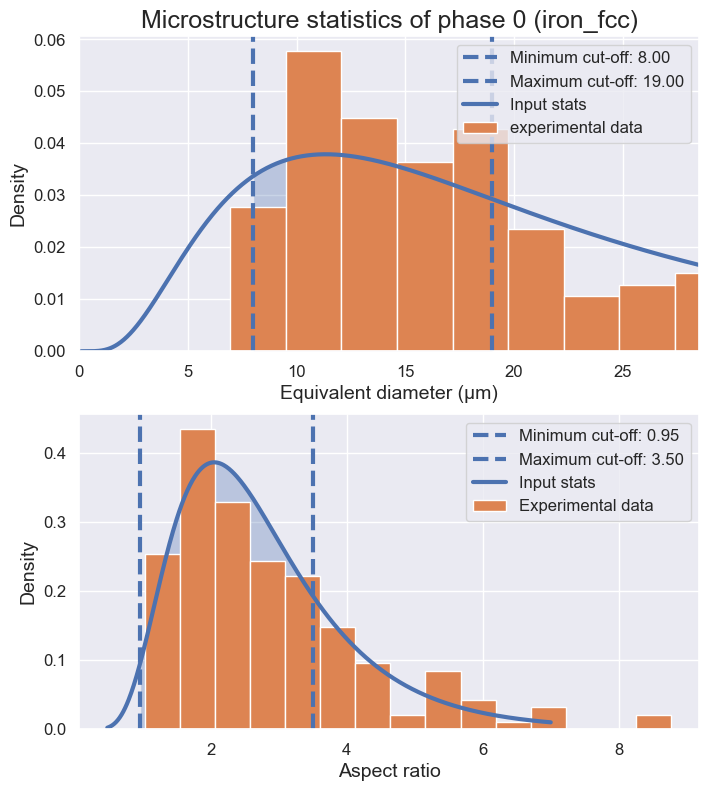

Creating an RVE based on user defined statistics
    Analyzed statistical data for phase iron_fcc (0)
    Total number of particles  = 88
  RVE characteristics:
    RVE side lengths (X, Y, Z) = (50, 50, 50) (um)
    Number of voxels (X, Y, Z) = (30, 30, 30)
    Voxel resolution (X, Y, Z) = [1.6667 1.6667 1.6667](um)
    Total number of voxels     = 27000


Considered phases (volume fraction): 
0: iron_fcc (100.0%)


Starting particle simulation
    Creating particles from distribution statistics
    Total volume of generated ellipsoids: 123586.7127881403
    Particle packing by growth simulation
Volume of simulation box: 125000
Volume of unscaled particles: 123586.7127881403
Initial volume of scaled ellipsoids: 123.5867127881404, targeted final volume: 80331.3633122912
Volume increment per time step: 123.5867127881403


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1441/1441 [01:54<00:00, 12.55it/s]


Actual final volume of ellipsoids: 80223.13995744595
Completed particle packing
330 overlapping particles detected after packing
Kinetic energy of particles after packing: 397863.49191652995



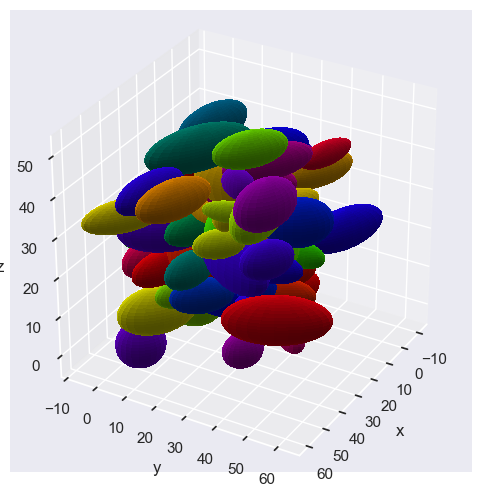

    Generating voxels inside RVE

Starting RVE voxelization
    Assigning voxels to grains


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [00:00<00:00, 23340108.82it/s]


Completed RVE voxelization

Optimum kernel estimated from mean orientations of grains
 estimating optimal kernel halfwidth: 0%
 estimate optimal kernel halfwidth: 10%
 estimate optimal kernel halfwidth: 20%
 estimate optimal kernel halfwidth: 30%
 estimate optimal kernel halfwidth: 40%
 estimate optimal kernel halfwidth: 50%
 estimate optimal kernel halfwidth: 60%
 estimate optimal kernel halfwidth: 70%
 estimate optimal kernel halfwidth: 80%
 estimate optimal kernel halfwidth: 90%
 estimate optimal kernel halfwidth: 100%

time =

   15.0894

I found another version of MTEX and remove it from the current search path!
initialize MTEX 5.5.2  .... done!
 
 For compatibility reasons MTEX is not using OpenMP.
 You may want to switch on OpenMP in the file <a href="matlab: edit mtex_settings">mtex_settings.m</a>
 


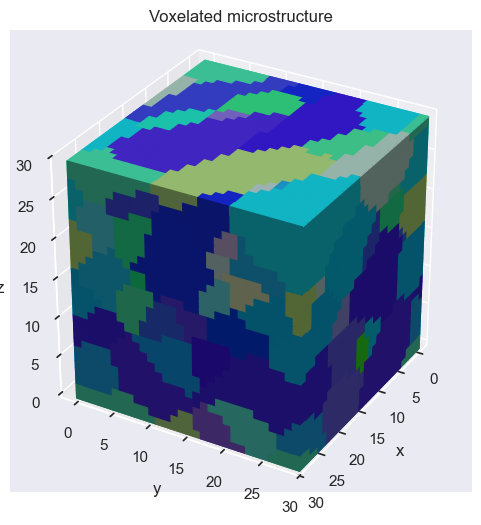

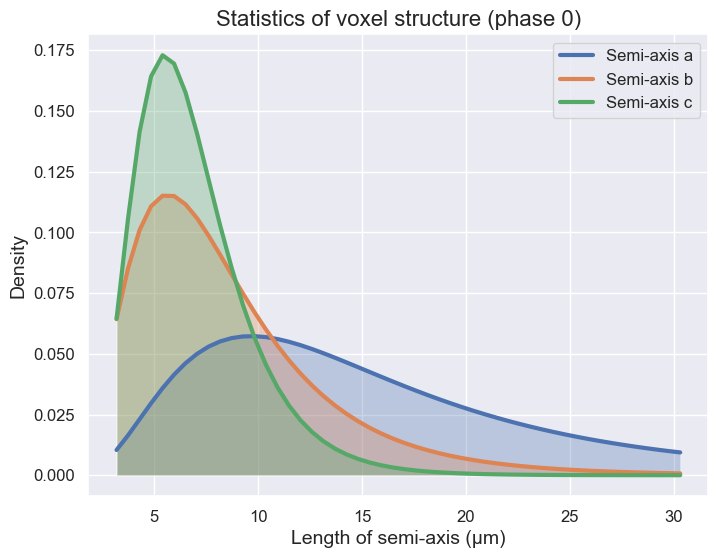


Statistical microstructure parameters of RVE
--------------------------------------------
Type	| a (µm) 	| b (µm) 	| c (µm) 	| std.dev	| rot.axis	| asp.ratio	| std.dev	| equ.dia. (µm)	| std.dev
Input	|  -      	|  -      	|  -      	|   -      	|     -   	|  2.519	|  0.4546	|     18.973 	|  0.7177
Output	|  13.869	|  7.487	|  6.387	|  0.5074	|     0   	|  1.999	|  0.6264	|     18.424 	|  0.4714


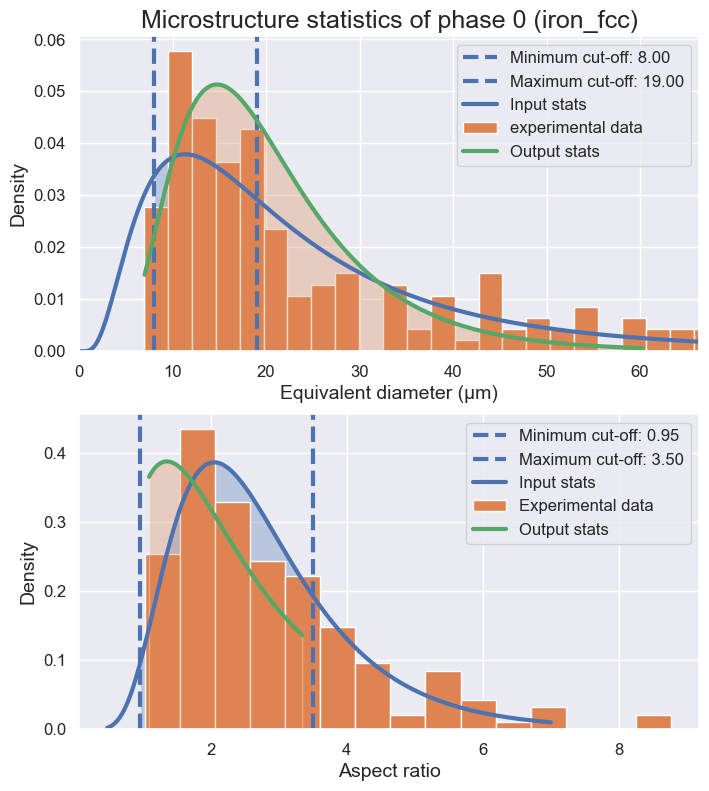


Writing RVE as ABAQUS file "./from_ebsd_vox30_gr88_pbc_geom.inp"
Using brick element type C3D8.


INFO:pyiron_log:Assigning a channel with the label None to the io key write_rve__None


---->DONE!



{'write_rve__None': None}

In [40]:
wf.run()

INFO:pyiron_log:Assigning a channel with the label fname to the io key get_ebsd__fname
INFO:pyiron_log:Assigning a channel with the label show_plot to the io key get_ebsd__show_plot
INFO:pyiron_log:Assigning a channel with the label Nv to the io key get_stats__Nv
INFO:pyiron_log:Assigning a channel with the label size to the io key get_stats__size
INFO:pyiron_log:Assigning a channel with the label periodic to the io key get_stats__periodic
INFO:pyiron_log:Assigning a channel with the label hist to the io key get_rve__hist
INFO:pyiron_log:Assigning a channel with the label show_plot to the io key get_rve__show_plot
INFO:pyiron_log:Assigning a channel with the label ialloy to the io key write_rve__ialloy
INFO:pyiron_log:Assigning a channel with the label None to the io key write_rve__None
INFO:pyiron_log:Assigning a channel with the label fname to the io key get_ebsd__fname
INFO:pyiron_log:Assigning a channel with the label show_plot to the io key get_ebsd__show_plot
INFO:pyiron_log:Assi

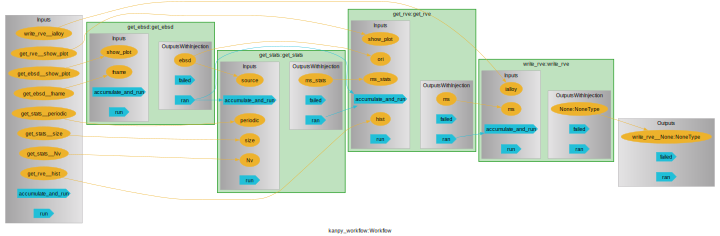

In [41]:
wf.draw(size=(10,12))


In [49]:
print(f'Number of grains in RVE {wf.get_rve.outputs.ms.value.Ngr}, periodic: {wf.get_rve.outputs.ms.value.rve.periodic}')
print('RVE statistical descriptors')
wf.get_stats.outputs.ms_stats.value

Number of grains in RVE 88, periodic: True
RVE statistical descriptors


{'Grain type': 'Elongated',
 'Equivalent diameter': {'sig': 0.7177384413787645,
  'loc': 0.0,
  'scale': 18.972525674890463,
  'cutoff_min': 8.0,
  'cutoff_max': 19.0},
 'RVE': {'sideX': 50, 'sideY': 50, 'sideZ': 50, 'Nx': 30, 'Ny': 30, 'Nz': 30},
 'Simulation': {'periodicity': True, 'output_units': 'um'},
 'Phase': {'Name': 'iron_fcc', 'Number': 0, 'Volume fraction': 1.0},
 'Aspect ratio': {'sig': 0.4546231908933487,
  'loc': 0.0,
  'scale': 2.519072886543862,
  'cutoff_min': 0.95,
  'cutoff_max': 3.5},
 'Tilt angle': {'kappa': 1.420764519917852,
  'loc': -0.21709379938469375,
  'cutoff_min': 0.0,
  'cutoff_max': 3.141592653589793},
 'Data': {'grain_size': array([  7.21516748,  10.89383927,   9.49258117,  13.92436699,
          10.09830386,  20.98919448,  13.99150806,   9.35047328,
          33.55271416,  29.88500126,  17.90695755,   9.88244296,
          16.70437743,  45.02191532,  16.4094472 ,  24.35690586,
          33.27821109,  11.23672069,  11.01729359,  12.83087576,
          5